In [1]:
import warnings
warnings.filterwarnings("ignore")

from pyomo.environ import *
from pyomo.dae import Integral, DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import numpy as np

## Optimal Control: Toy Problem

Note: This is almost 100% AI-generated with the following prompt: "Can you write a code in Pyomo DAE that implements optimal control for a toy problem?"

We consider the following **optimal control problem**:

\begin{aligned}
\min_{x(t),\,u(t)} \quad & J = \int_{0}^{T} \Big[ (x(t) - 1)^2 + 0.01\,u(t)^2 \Big]\,dt \\
\text{subject to} \quad & \dot{x}(t) = -x(t) + u(t), \\
& x(0) = 0, \\
& -2 \le u(t) \le 2, \\
& T = 2.
\end{aligned}


### Description

- **Objective:**  
  Track the target state $ x(t) = 1 $ while minimizing control effort.  
  The quadratic penalty on $ u(t) $ prevents excessively large control actions.

- **Dynamics:**  
  A simple first-order linear system: $ \dot{x}(t) = -x(t) + u(t) $

- **Constraints:**  
  - Control bounds: $ -2 \leq u(t) \leq 2 $
  - Initial condition: $ x(0) = 0, u(0) = 0 $
  - Allow only 1 collocation pt for $u(t)$ per finite element
  - Fixed time horizon: $ T = 2 $

### Solution Approach

The problem is discretized and solved using **Pyomo.DAE** with a **Lagrange–Radau collocation scheme**:
- Number of finite elements: $ N_{\text{fe}} = 20 $
- Number of collocation points per element: $ N_{\text{cp}} = 3 $

The resulting nonlinear program (NLP) is solved using **IPOPT**.

The solution yields:
- Optimal **state trajectory** $ x(t) $
- Optimal **control profile** $ u(t) $
- Minimum objective value $ J^* $


Please recompile / update your pynumero_ASL library.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      562
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:      182
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       61
                     variables w

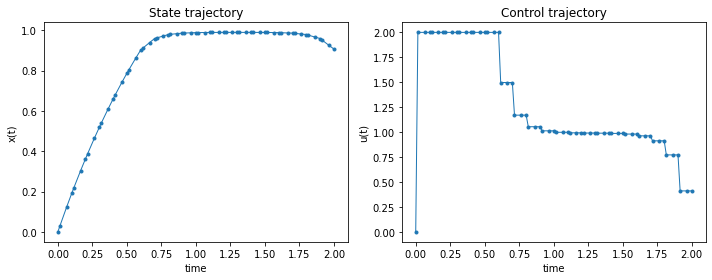

In [2]:
def build_and_solve_optimal_control(T, nfe, ncp, show_plots):
    model = ConcreteModel()

    # ---- time ----
    model.tf = T
    model.t = ContinuousSet(bounds=(0, model.tf))

    # ---- variables ----
    model.x = Var(model.t)                 # state
    model.u = Var(model.t, bounds=(-2, 2)) # control
    model.dx = DerivativeVar(model.x, wrt=model.t)

    # ---- dynamics ----
    def _ode(m, tt):
        # skip first point because derivative at first collocation node is handled by DAE transform
        if tt == m.t.first():
            return Constraint.Skip
        return m.dx[tt] == -m.x[tt] + m.u[tt]
    model.ode = Constraint(model.t, rule=_ode)

    # ---- initial condition ----
    model.init_x = Constraint(expr=model.x[model.t.first()] == 0.0)
    model.init_u = Constraint(expr=model.u[model.t.first()] == 0.0)

    def integrand_rule(m, tt):
        return (m.x[tt] - 1.0)**2 + 0.01 * m.u[tt]**2

    # ---- Objective ----
    model.J = Integral(model.t, wrt=model.t, rule=integrand_rule)
    model.obj = Objective(expr=model.J, sense=minimize)

    # ---- discretize with collocation ----
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(model, nfe=nfe, ncp=ncp, scheme='LAGRANGE-RADAU')
    discretizer.reduce_collocation_points(model, var=model.u, ncp=1, contset=model.t)

    # ---- solve ----
    solver = SolverFactory('cyipopt')
    res = solver.solve(model, tee=True)

    # ---- extract solution on discretized time points ----
    t_disc = sorted([tt for tt in model.t])  # after discretization, model.t contains collocation points
    x_sol = np.array([value(model.x[tt]) for tt in t_disc])
    u_sol = np.array([value(model.u[tt]) for tt in t_disc])

    print("\nObjective J = ", value(model.obj))
    print("Number of time points (discretized) =", len(t_disc))

    if show_plots:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(t_disc, x_sol, '-o', linewidth=1, markersize=3)
        plt.xlabel('time')
        plt.ylabel('x(t)')
        plt.title('State trajectory')

        plt.subplot(1,2,2)
        plt.plot(t_disc, u_sol, '-o', linewidth=1, markersize=3)
        plt.xlabel('time')
        plt.ylabel('u(t)')
        plt.title('Control trajectory')

        plt.tight_layout()
        plt.show()

    # return model and arrays for further analysis
    return model, np.array(t_disc), x_sol, u_sol

if __name__ == "__main__":
    model, t, x, u = build_and_solve_optimal_control(T=2.0, nfe=20, ncp=3, show_plots=True)
